# Patch Size as Connectivity

We analyze how well patch size would work as connectivity measure.

## Code Setup

In [60]:
# Path to main directory
LOCAL_PATH = "data/CA-Final"
DATA_PATH = LOCAL_PATH

In [61]:
import os
import pandas as pd
import numpy as np
import sys
from IPython.core.display import HTML

In [62]:
sys.path.append(os.path.join(os.getcwd(), "birdmaps"))
from birdmaps import bird_runs

## Bird Run Definition

In [63]:
bird_run = bird_runs.BirdRun(DATA_PATH)

In [64]:
def wmean(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def wcov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - wmean(x, w)) * (y - wmean(y, w))) / np.sum(w)

def wcorr(x, y, w):
    """Weighted Correlation"""
    return wcov(x, y, w) / np.sqrt(wcov(x, x, w) * wcov(y, y, w))

In [65]:
import matplotlib.pyplot as plt
from matplotlib import cm
import colorcet
from scipy import stats
from sklearn.linear_model import LinearRegression


In [66]:
def plot_bird_ratios_locations(bird, max_checklists=10000):
    bird_name = bird.name
    df = pd.read_csv(bird.obs_csv_path)
    # limit to squares where max hab > 0.9
    df = df.loc[lambda r : r["max_hab"] > 0.9]
    df = df.loc[lambda r : r["NumChecklists"] <= max_checklists]
    print("Number of locations:", len(df))
    # Computes the log repopulation. 
    df["logsize"] = df.apply(lambda row : np.log(row["max_repop"]), axis=1)
    # Computes the bin size. 
    max_log = df["logsize"].max()
    bin_size = 1
    # Computes the bin for each datum. 
    df["size_bin"] = df.apply(lambda row : int(row["logsize"] / bin_size), axis = 1)
    n_bins = 14 # df["size_bin"].max() + 1
    # Computes bin size. 
    sizes = [df[df["size_bin"] == i]["Square"].count() for i in range(n_bins)]
    pys = [df[df["size_bin"] == i]["BirdRatio"].mean() for i in range(n_bins)]
    pxs = [i * bin_size for i in range(n_bins)]
    # Filters out empty bins. 
    ys, xs, ss = [], [], []
    tys, txs, tss = [], [], []
    for i, s in enumerate(sizes):
        tss.append(s)
        if s > 0:
            tys.append(pys[i])
            txs.append(pxs[i])
            ys.append(pys[i])
            xs.append(pxs[i])
            ss.append(s)
        else:
            tys.append(None)
            txs.append(pxs[i])
    axs, ays, asizes = np.array(xs), np.array(ys), np.array(ss)
    corr = wcorr(axs, ays, asizes)
    print("Correlation:", corr)
    reg = LinearRegression().fit(axs.reshape(-1, 1), ays.reshape(-1, 1), ss)
    r_square = reg.score(axs.reshape(-1, 1), ays.reshape(-1, 1), ss)
    print("R^2:", r_square)
    df_display = pd.DataFrame({"Patch size, km$^2$": np.exp(txs) * (0.3 ** 2), "Sightings": tys, "N": tss})
    fig, ax = plt.subplots()
    ax.scatter(xs, ys, s=ss, alpha=0.5)
    ax.set_xlabel(r"Patch size, km$^2$")
    ax.set_ylabel("Average sightings per checklist")
    # ax.set_title(bird.name)
    ymin, ymax = np.min(ys), np.max(ys)
    ylmin, ylmax = ymin - 0.2 * (ymax - ymin), ymax + 0.2 * (ymax - ymin)
    ax.set_ylim((0, ylmax))
    ax.set_xlim((-1, max(xs) * 1.2))
    x_km2 = [0.1, 1, 10, 100, 1000, 10000, 100000]
    plt.xticks(ticks=[np.log(x / (0.3 * 0.3)) for x in x_km2], labels=x_km2)
    ax.grid(True)
    fig.tight_layout()
    print("Average on locations with max {} checklists".format(max_checklists))
    plt.show()
    # fig.savefig("Figures/Sightings_vs_Patch_Size_{}.pdf".format(
    #     bird.nickname), bbox_inches="tight", format="pdf")
    display(HTML(df_display.to_html()))
    df_display.to_latex("Figures/Sightings_vs_Patch_Size_{}.tex".format(
        bird.nickname), index=False, float_format="%.3f", escape=False, na_rep="---")

In [67]:
def welch_t_test(bird, lower_threshold=1/3, upper_threshold=2/3):   
    bird_name = bird.name
    df = pd.read_csv(bird.obs_csv_path)
    # limit to squares where max hab > 0.9
    df = df.loc[lambda r : r["max_hab"] > 0.9]
    print("Number of loactions:", len(df))
    df_low = df.loc[lambda r : r["max_repop"] <= lower_threshold]
    df_high = df.loc[lambda r : r["max_repop"] >= upper_threshold]
    print("Number of low connectivity locations:", len(df_low))
    print("Number of high connectivity locations:", len(df_high))
    print("Average sightings per checklist in low connectivity locations:", df_low["BirdRatio"].mean())
    print("Average sightings per checklist in high connectivity locations:", df_high["BirdRatio"].mean())
    print("Welch's t-test p-value:", stats.ttest_ind(df_low["BirdRatio"], df_high["BirdRatio"], equal_var=False)[1])
 

## Acorn Woodpecker

Number of loactions: 6818
Number of low connectivity locations: 1862
Number of high connectivity locations: 4629
Average sightings per checklist in low connectivity locations: 0.9399074311739835
Average sightings per checklist in high connectivity locations: 1.5179786967913624
Welch's t-test p-value: 3.982133472178329e-22

Number of locations: 6818
Correlation: 0.6320488157619136
R^2: 0.39948570550603746
Average on locations with max 10000 checklists


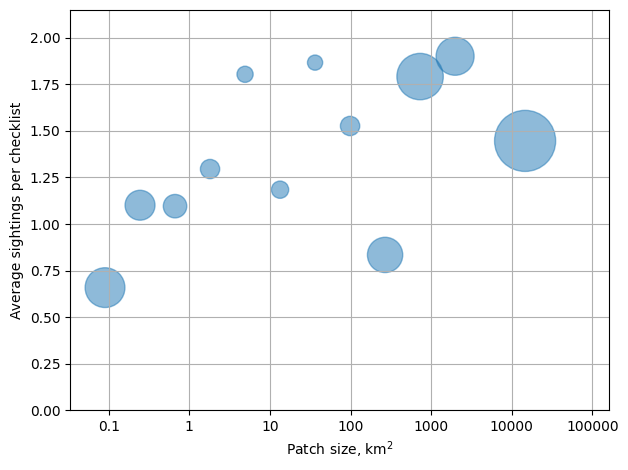

,"Patch size, km$^2$",Sightings,N
0,0.090000,0.658202,821
1,0.244645,1.100868,465
2,0.665015,1.095848,286
3,1.807698,1.295330,193
4,4.913834,1.804375,136
5,13.357184,1.184403,155
6,36.308591,1.867153,120
7,98.696984,1.526685,194
8,268.286219,0.833897,646
9,729.277553,1.792197,1117


In [68]:

bird = bird_run.get_bird_run(
    "acowoo", "Acorn Woodpecker", run_name="patch_sizes_torch"
)
welch_t_test(bird, lower_threshold=10 / (0.3 * 0.3), upper_threshold=100 / (0.3 * 0.3))
print()
plot_bird_ratios_locations(bird)


Number of loactions: 5806
Number of low connectivity locations: 1263
Number of high connectivity locations: 4131
Average sightings per checklist in low connectivity locations: 0.7791926447427462
Average sightings per checklist in high connectivity locations: 1.2560041825802715
Welch's t-test p-value: 1.2006184415618206e-17

Number of locations: 5806
Correlation: 0.395346710800412
R^2: 0.1562990217407051
Average on locations with max 10000 checklists


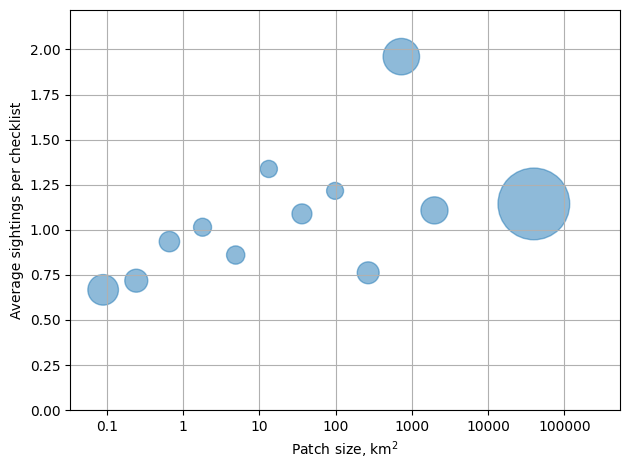

,"Patch size, km$^2$",Sightings,N
0,0.090000,0.666942,485
1,0.244645,0.717783,274
2,0.665015,0.934509,216
3,1.807698,1.014247,168
4,4.913834,0.860062,173
5,13.357184,1.337432,153
6,36.308591,1.088283,206
7,98.696984,1.215878,149
8,268.286219,0.761519,249
9,729.277553,1.960259,689


In [69]:

bird = bird_run.get_bird_run(
    "stejay", "Steller's Jay", run_name="patch_sizes_torch", 
)
welch_t_test(bird, lower_threshold=10 / (0.3 * 0.3), upper_threshold=100 / (0.3 * 0.3))
print()
plot_bird_ratios_locations(bird)

In [70]:
birds_for_paper = []

birds_for_paper.append(bird_run.get_bird_run(
    "acowoo", "Acorn Woodpecker", run_name="patch_sizes_torch"))

birds_for_paper.append(bird_run.get_bird_run(
    "stejay", "Steller's Jay", run_name="patch_sizes_torch"))

Number of loactions: 6818
Average on locations with max 10000 checklists
Number of loactions: 5806
Average on locations with max 10000 checklists


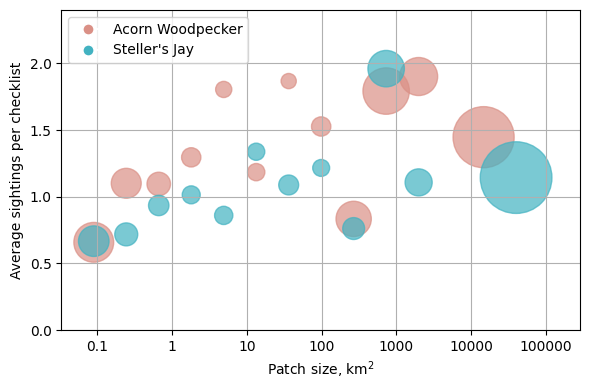

In [71]:
from matplotlib.lines import Line2D  # for legend handle

def plot_birds_ratios(bird_ls, max_checklists=10000):
    fig, ax = plt.subplots(figsize=(6, 4))

    cmap = colorcet.cm.cyclic_isoluminant_r
    # cmap = plt.cm.inferno
    unique_birds = list(b.nickname for b in bird_ls)
    num_birds = len(unique_birds)
    colors = cmap(np.linspace(0, 1 - 1/num_birds, num_birds))
    colormap = {b: c for b, c in zip(unique_birds, colors)}
    birdname = {b.nickname: b.name for b in bird_ls}
    for bird in bird_ls:
        df = pd.read_csv(bird.obs_csv_path)
        # limit to squares where max hab > 0.9
        df = df.loc[lambda r : r["max_hab"] > 0.9]
        df = df.loc[lambda r : r["NumChecklists"] <= max_checklists]
        print("Number of loactions:", len(df))
        # Computes the log repopulation. 
        df["logsize"] = df.apply(lambda row : np.log(row["max_repop"]), axis=1)
        # Computes the bin size. 
        max_log = df["logsize"].max()
        bin_size = 1
        # Computes the bin for each datum. 
        df["size_bin"] = df.apply(lambda row : int(row["logsize"] / bin_size), axis = 1)
        n_bins = df["size_bin"].max() + 1
        # Computes bin size. 
        sizes = [df[df["size_bin"] == i]["Square"].count() for i in range(n_bins)]
        pys = [df[df["size_bin"] == i]["BirdRatio"].mean() for i in range(n_bins)]
        pxs = [i * bin_size for i in range(n_bins)]
        # Filters out empty bins. 
        ys, xs, ss = [], [], []
        for i, s in enumerate(sizes):
            if s > 0:
                ys.append(pys[i])
                xs.append(pxs[i])
                ss.append(s)
        ax.scatter(xs, ys, s=ss, color=colormap[bird.nickname], alpha=0.7, label=bird.name)
        fig.tight_layout()
        print("Average on locations with max {} checklists".format(max_checklists))

    ax.set_xlabel(r"Patch size, km$^2$")
    ax.set_ylabel("Average sightings per checklist")
    x_km2 = [0.1, 1, 10, 100, 1000, 10000, 100000]
    plt.xticks(ticks=[np.log(x / (0.3 * 0.3)) for x in x_km2], labels=x_km2)
    ymin, ymax = np.min(ys), np.max(ys)
    ylmin, ylmax = ymin - 0.2 * (ymax - ymin), ymax + 0.2 * (ymax - ymin)
    ax.set_ylim((0, 2.4))
    ax.set_xlim((-1, np.log(100000) * 1.3))
    ax.grid(True)
    fig.tight_layout()

    # add a legend
    handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=c, label=birdname[b], markersize=8) for b, c in colormap.items()]
    ax.legend(handles=handles, loc='upper left')

    plt.show()
    
    fig.savefig("Figures/SightingsVsPatchSize.pdf", format="pdf")

plot_birds_ratios(birds_for_paper)